# Analytic spiral

We create a Magritte model from an analytic description of an Archimedean spiral outflow.
The description of the model is based on [Homan et al. (2015)](https://www.aanda.org/articles/aa/full_html/2015/07/aa25933-15/aa25933-15.html).

## Setup

Import the required functionalty.

In [1]:
import magritte.setup    as setup                   # Model setup
import magritte.core     as magritte                # Core functionality
import magritte.mesher   as mesher                  # Mesher
import numpy             as np                      # Data structures
import meshio
import warnings                                     # Hide warnings
warnings.filterwarnings('ignore')                   # especially for yt
import yt                                           # 3D plotting
import os

from tqdm                import tqdm                # Progress bars
from astropy             import units, constants    # Unit conversions
from scipy.spatial       import Delaunay, cKDTree   # Finding neighbors
from yt.funcs            import mylog               # To avoid yt output 
mylog.setLevel(40)                                  # as error messages

Define a working directory (you will have to change this; it must be an **absolute path**).

In [2]:
wdir = "/lhome/thomasc/Magritte-examples/Analytic_spiral/"

Create the working directory.

In [3]:
!mkdir -p $wdir

Define file names.

In [4]:
model_file = os.path.join(wdir, 'model_analytic_spiral.hdf5')   # Resulting Magritte model
lamda_file = os.path.join(wdir, 'co.txt'                    )   # Line data file
bmesh_name = os.path.join(wdir, 'analytic_spiral'           )   # bachground mesh name (no extension!)

We use a data file that can be downloaded with the following links.

In [5]:
lamda_link = "https://home.strw.leidenuniv.nl/~moldata/datafiles/co.dat"

Dowload the snapshot and the linedata (``%%capture`` is just used to suppress the output).

In [6]:
%%capture
!wget $lamda_link --output-document $lamda_file

## Spiral parameters

The functions below describe the spiral structure, based on the parameters in [Homan et al. (2015)](https://www.aanda.org/articles/aa/full_html/2015/07/aa25933-15/aa25933-15.html).

In [7]:
phi_0 =   0 / 180.0 * np.pi                         # [radian]
alpha =  15 / 180.0 * np.pi                         # [radian]
sigma =  20               * constants.au.si.value   # [m]
b     = 270 / (2.0*np.pi) * constants.au.si.value   # [m]


def r_0(r, theta, phi):
    return b*(phi - phi_0)


def sigma_r(r, theta, phi):
    return sigma


def theta_0(r, theta, phi):
    return 0.5*np.pi


def sigma_theta(r, theta, phi):
    return alpha


def S(r, theta, phi):
    """
    Spiral-shaped distribution function.
    """
    rd = (r     - r_0    (r,theta,phi)) / sigma_r    (r,theta,phi)
    td = (theta - theta_0(r,theta,phi)) / sigma_theta(r,theta,phi)
    return np.exp(-0.5*(rd**2 + td**2))


def SS(r, theta, phi):
    """
    Spiral-shaped distribution function.
    (Including 10 windings.)
    """
    result = 0.0
    for i in range(10):
        result += S(r, theta, phi+2.0*np.pi*i)
    return result

## Physical parameters

In [8]:
R_max   = 600.0 * constants.au.si.value                    # [m]
R_star  =   1.0 * constants.R_sun.si.value                 # [m]
v_inf   = 14.5e+3                                          # [m/s]
beta    = 0.4                                              # [.]
Mdot    = 1.5e-6 * (constants.M_sun/units.year).si.value   # [kg/s]
R_0     = 2.0 * R_star                                     # [m]
epsilon = 0.5                                              # [.]
T_star  = 2330.0                                           # [K]
T_0     = 60.0                                             # [K]
rho_max = 1.0e-11                                          # [kg/m^3]


def v_r(r):
    """
    Beta-law velocity profile.
    """
    return v_inf * (1.0 - R_0/r)**beta


def rho_regular(r):
    """
    Density profile assuming a regular, spherically symmetric outflow.
    """
    return Mdot / (4.0*np.pi*r**2*v_r(r))


def rho_spiral(r, theta, phi):
    """
    Density profile assuming a spiral outflow.
    """
    return rho_max * (2.0*np.pi*b/r)**2 * SS(r, theta, phi)


def rho_wind(r, theta, phi):
    """
    Wind density, combined regular and spiral outflow.
    """
    return rho_regular(r) + rho_spiral(r, theta, phi)


def T_regular(r):
    """
    Temperature profile assuming a regular, spherically symmetric outflow.
    """
    return T_star * (R_star/r)**epsilon


def T_spiral(r, theta, phi):
    """
    Temperature profile assuming a spiral outflow.
    """
    return T_0 * SS(r, theta, phi)


def T_wind(r, theta, phi):
    """
    Wind temperature, combined regular and spiral outflow.
    """
    return T_regular(r) + T_spiral(r, theta, phi)

In [9]:
def spherical(x,y,z):
    """
    Convert cartesian to spherical coordinates.
    """
    r = np.sqrt   (x**2 + y**2 + z**2)
    t = np.arccos (z/r)
    p = np.arctan2(y,x)
    return (r,t,p)

## Create background mesh (with desired mesh element sizes)

Define the desired mesh element size in a ($100 \times 100 \times 100$) cube.

In [10]:
resolution = 100

xs = np.linspace(-R_max, +R_max, resolution, endpoint=True)
ys = np.linspace(-R_max, +R_max, resolution, endpoint=True)
zs = np.linspace(-R_max, +R_max, resolution, endpoint=True)

(Xs, Ys, Zs) = np.meshgrid(xs, ys, zs)

position = np.array((Xs.ravel(), Ys.ravel(), Zs.ravel())).T

# Compute the corresponding spherical coordinates
Rs = np.sqrt   (Xs**2 + Ys**2 + Zs**2)
Ts = np.arccos (Zs/Rs)
Ps = np.arctan2(Ys,Xs)

# Evaluate the density on the cube
rhos = rho_wind(Rs, Ts, Ps)
rhos = np.nan_to_num(rhos, nan=1.0)

Now we remesh the grid using the built-in remesher

In [11]:
positions_reduced, nb_boundary = mesher.remesh_point_cloud(position, rhos.ravel(), max_depth=10, threshold= 2e-1, hullorder=4)

new interior points:  583111
number boundary points:  1538


We add a spherical inner boundary at 0.04*R_max

In [12]:
healpy_order = 5 #using healpy to determine where to place the 12*healpy_order**2 boundary points on the sphere
origin = np.array([0.0,0.0,0.0]).T #the origin of the inner boundary sphere
positions_reduced, nb_boundary = mesher.point_cloud_add_spherical_inner_boundary(positions_reduced, nb_boundary, 0.04*R_max, healpy_order=healpy_order, origin=origin)
print("number of points in reduced grid: ", len(positions_reduced))

number of points in reduced grid:  584918


We add a spherical outer boundary at R_max

In [13]:
healpy_order = 15 #using healpy to determine where to place the 12*healpy_order**2 boundary points on the sphere
origin = np.array([0.0,0.0,0.0]).T #the origin of the inner boundary sphere
positions_reduced, nb_boundary = mesher.point_cloud_add_spherical_outer_boundary(positions_reduced, nb_boundary, R_max, healpy_order=healpy_order, origin=origin)
print("number of points in reduced grid: ", len(positions_reduced))

number of points in reduced grid:  291580


In [14]:
npoints = len(positions_reduced)

XCO   = 6.0e-4   # [.]
vturb = 1.5e+3   # [m/s]


def density(rr):
    """
    Density function.
    """
    (r, t, p) = spherical(rr[0], rr[1], rr[2])
    if (r < R_0):
        r = R_0
    return rho_wind(r, t, p)


def abn_nH2(rr):
    """
    H2 number density function.
    """
    return density(rr) / (2.01588 * constants.u.si.value)


def abn_nCO(rr):
    """
    CO number density function.
    """
    return XCO * abn_nH2(rr)


def temp(rr):
    """
    Temperature function.
    """
    (r, t, p) = spherical(rr[0], rr[1], rr[2])
    if (r < R_0):
        r = R_0
    return T_wind(r, t, p)

        
def turb(rr):
    """
    !!! Peculiar Magritte thing...
    Square turbulent speed as fraction of the speed of light.
    """
    return (vturb/constants.c.si.value)**2


def velo(rr):
    """
    Velocity function.
    """
    (r, t, p) = spherical(rr[0], rr[1], rr[2])
    if (r < R_0):
        r = R_0
    return v_r(r) / constants.c.si.value * np.array([rr[0], rr[1], rr[2]]) / r


# Extract Delaunay vertices (= Voronoi neighbors)
delaunay = Delaunay(positions_reduced)
(indptr, indices) = delaunay.vertex_neighbor_vertices
neighbors = [indices[indptr[k]:indptr[k+1]] for k in range(npoints)]
nbs       = [n for sublist in neighbors for n in sublist]
n_nbs     = [len(sublist) for sublist in neighbors]

# Convenience arrays
zeros = np.zeros(npoints)
ones  = np.ones (npoints)

Convert model functions to arrays based the model mesh.

In [15]:
position = positions_reduced
velocity = np.array([velo   (rr) for rr in positions_reduced])
nH2      = np.array([abn_nH2(rr) for rr in positions_reduced])
nCO      = np.array([abn_nCO(rr) for rr in positions_reduced])
tmp      = np.array([temp   (rr) for rr in positions_reduced])
trb      = np.array([turb   (rr) for rr in positions_reduced])

## Create model

Now all data is read, we can use it to construct a Magritte model.

<div class="alert alert-warning">

Warning

Since we do not aim to do self-consistent non-LTE simulations in these examples, we only consider the first radiative transition of CO (J=1-0). To consider all transitions, use `setup.set_linedata_from_LAMDA_file` as in the commented line below it.

</div>

In [16]:
model = magritte.Model ()                              # Create model object

model.parameters.set_model_name         (model_file)   # Magritte model file
model.parameters.set_dimension          (3)            # This is a 3D model
model.parameters.set_npoints            (npoints)      # Number of points
model.parameters.set_nrays              (12)           # Number of rays  
model.parameters.set_nspecs             (5)            # Number of species (min. 5)
model.parameters.set_nlspecs            (1)            # Number of line species
model.parameters.set_nquads             (51)           # Number of quadrature points

model.geometry.points.position.set(position)
model.geometry.points.velocity.set(velocity)

model.geometry.points.  neighbors.set(  nbs)
model.geometry.points.n_neighbors.set(n_nbs)

model.chemistry.species.abundance = np.array((zeros, nCO, nH2, zeros, ones)).T
model.chemistry.species.symbol    = ['dummy0', 'CO', 'H2', 'e-', 'dummy1']

model.thermodynamics.temperature.gas  .set(tmp)
model.thermodynamics.turbulence.vturb2.set(trb)

model.parameters.set_nboundary(nb_boundary)
model.geometry.boundary.boundary2point.set(np.arange(nb_boundary))

model = setup.set_boundary_condition_CMB  (model)
model = setup.set_uniform_rays            (model)
model = setup.set_linedata_from_LAMDA_file(model, lamda_file, {'considered transitions': [0]})
# model = setup.set_linedata_from_LAMDA_file(model, lamda_file)   # Consider all transitions
model = setup.set_quadrature              (model)

model.write()

Not considering all radiative transitions on the data file but only the specified ones!
Writing parameters...
Writing points...
Writing rays...
Writing boundary...
Writing chemistry...
Writing species...
Writing thermodynamics...
Writing temperature...
Writing turbulence...
Writing lines...
Writing lineProducingSpecies...
Writing linedata...
ncolpoar = 2
--- colpoar = 0
Writing collisionPartner...
(l, c) = 0, 0
--- colpoar = 1
Writing collisionPartner...
(l, c) = 0, 1
Writing quadrature...
Writing populations...
Writing radiation...
Writing frequencies...


## Plot model

Load the data in a `yt` unstructured mesh.

In [17]:
ds = yt.load_unstructured_mesh(
    connectivity = delaunay.simplices.astype(np.int64),
    coordinates  = delaunay.points.astype(np.float64) * 100.0, # yt expects cm not m 
    node_data    = {('connect1', 'n'): nCO[delaunay.simplices].astype(np.float64)}
)

Plot a slice through the mesh orthogonal to the z-axis and x-axis.


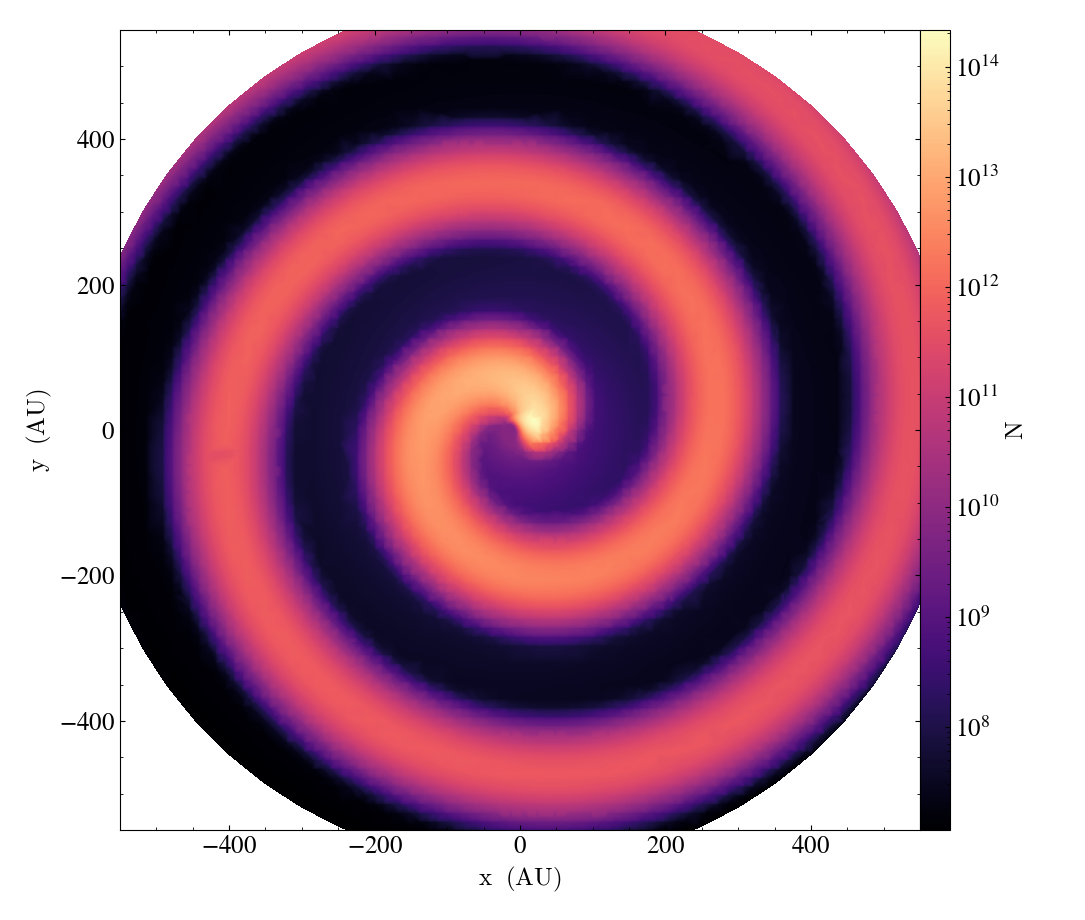

In [18]:
sl = yt.SlicePlot (ds, 'z', ('connect1', 'n'))
sl.set_cmap       (('connect1', 'n'), 'magma')
sl.zoom           (1.2)


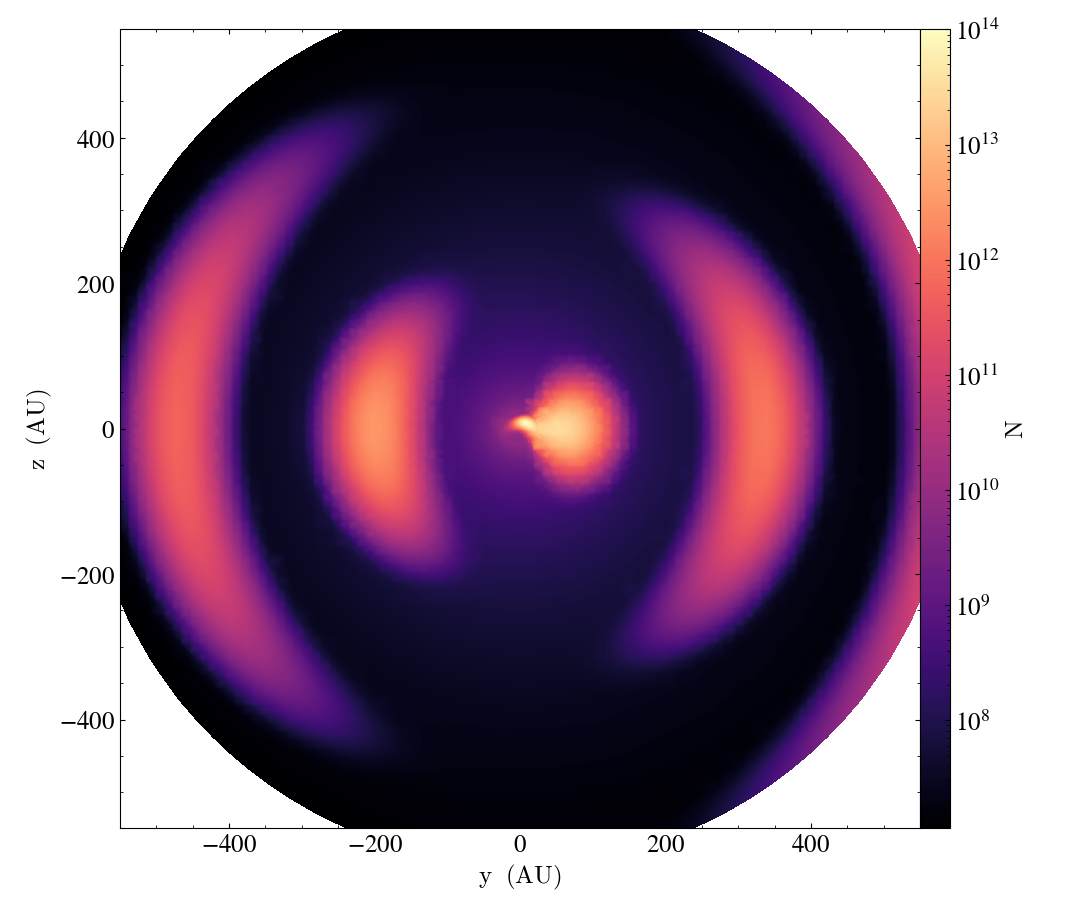

In [19]:
sl = yt.SlicePlot (ds, 'x', ('connect1', 'n'))
sl.set_cmap       (('connect1', 'n'), 'magma')
sl.zoom           (1.2)

Show meshes on the plots.


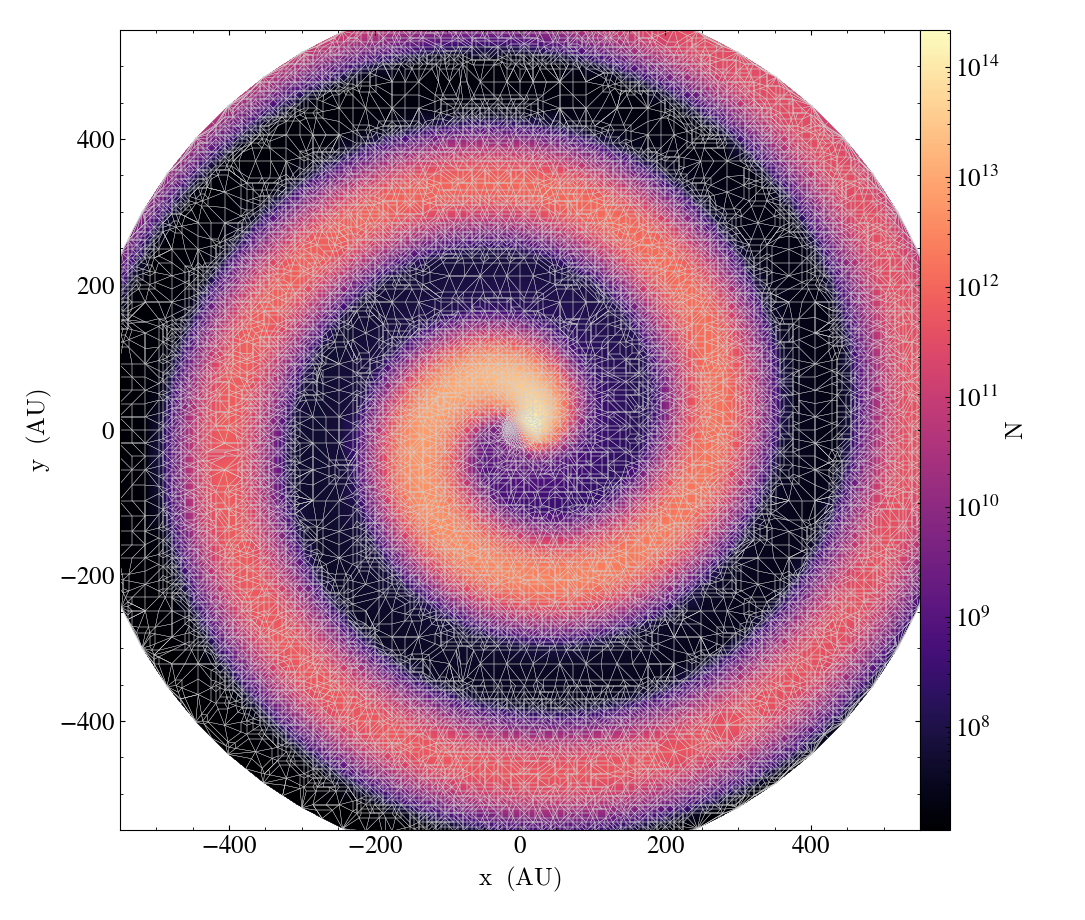

In [20]:
sl = yt.SlicePlot      (ds, 'z', ('connect1', 'n'))
sl.set_cmap            (('connect1', 'n'), 'magma')
sl.zoom                (1.2)
sl.annotate_mesh_lines (plot_args={'color':'lightgrey', 'linewidths':[.25]})


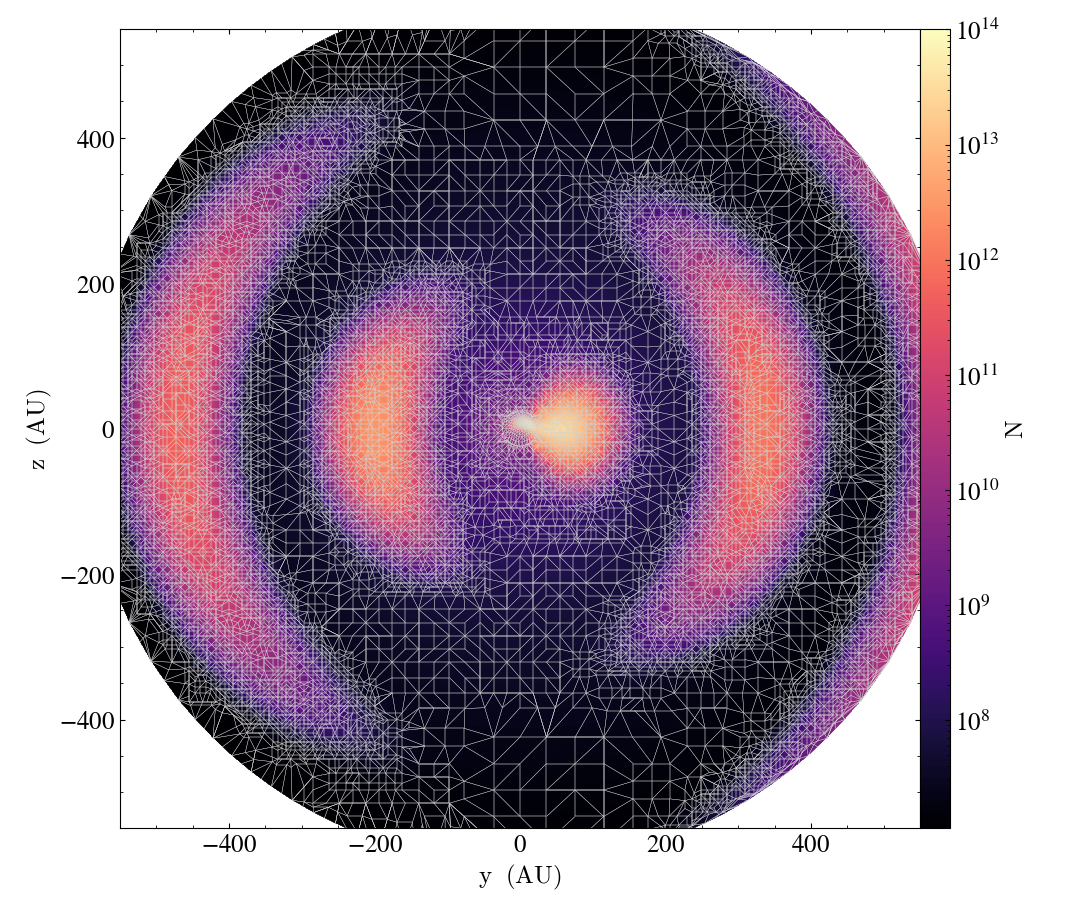

In [21]:
sl = yt.SlicePlot      (ds, 'x', ('connect1', 'n'))
sl.set_cmap            (('connect1', 'n'), 'magma')
sl.zoom                (1.2)
sl.annotate_mesh_lines (plot_args={'color':'lightgrey', 'linewidths':[.25]})